# Image Segmentation Model - MONAI

##### Imports

In [1]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import BasicUNetPlusPlus
from monai.networks.blocks import Convolution
from monai.losses import DiceLoss
from monai.metrics import MeanIoU
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image
monai.utils.set_determinism(17)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime

##### Hyperparamters

In [2]:
batch_size = 4
num_workers = 4
learning_rate = 0.0005
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask

In [4]:
class CellDataset(Dataset):
    def __init__(self, data_dir, mode='train'):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files_list = os.listdir(self.image_dir)
        self.mask_files_list = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        train_image_files, val_image_files, test_image_files, train_mask_files, val_mask_files, test_mask_files = self.split_data_files()
        
        if mode == 'train':
            self.image_files, self.mask_files = train_image_files, train_mask_files
        elif mode == 'test':
            self.image_files, self.mask_files = test_image_files, test_mask_files
        elif mode == 'val':
            self.image_files, self.mask_files = val_image_files, val_mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask
    
    def split_data_files(self):
        train_image_files, rem_image_files, train_mask_files, rem_mask_files = train_test_split(self.image_files_list, self.mask_files_list, test_size=0.2, random_state=42)
        val_image_files, test_image_files, val_mask_files, test_mask_files = train_test_split(rem_image_files, rem_mask_files, test_size=0.5, random_state=42)
        return train_image_files, val_image_files, test_image_files, train_mask_files, val_mask_files, test_mask_files

In [5]:
DATA_DIR = '../data/segmentation_dataset/'
train_dataset = CellDataset(DATA_DIR, mode='train')
val_dataset = CellDataset(DATA_DIR, mode='val')
test_dataset = CellDataset(DATA_DIR, mode='test')

In [6]:
train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(530, 65, 70)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [8]:
len(train_loader), len(val_loader), len(test_loader)

(133, 17, 18)

##### Model Definition - UNet

In [9]:
in_channels = 8
out_channels = 1
model = BasicUNetPlusPlus(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    features=(16, 32, 64, 128, 64, 32),
).to(device)
print(model)

BasicUNetPlusPlus features: (16, 32, 64, 128, 64, 32).
BasicUNetPlusPlus(
  (conv_0_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (conv_1_0): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1

##### Loss Function and Optimizer

In [10]:
criterion = DiceLoss(sigmoid=True, jaccard=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training and Validation Loop

In [11]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)[0]
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)[0]

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  3%|▎         | 1/30 [01:52<54:27, 112.69s/it]

Epoch 1/30, Train Loss: 0.3773, Test Loss: 0.3010


  7%|▋         | 2/30 [03:55<55:27, 118.83s/it]

Epoch 2/30, Train Loss: 0.3002, Test Loss: 0.2623


 10%|█         | 3/30 [06:21<59:04, 131.27s/it]

Epoch 3/30, Train Loss: 0.2692, Test Loss: 0.2371


 13%|█▎        | 4/30 [08:32<56:45, 130.97s/it]

Epoch 4/30, Train Loss: 0.2526, Test Loss: 0.2241


 17%|█▋        | 5/30 [10:50<55:37, 133.50s/it]

Epoch 5/30, Train Loss: 0.2416, Test Loss: 0.2245


 20%|██        | 6/30 [13:15<54:54, 137.28s/it]

Epoch 6/30, Train Loss: 0.2352, Test Loss: 0.2163


 23%|██▎       | 7/30 [15:46<54:24, 141.95s/it]

Epoch 7/30, Train Loss: 0.2315, Test Loss: 0.2150


 27%|██▋       | 8/30 [18:17<53:04, 144.74s/it]

Epoch 8/30, Train Loss: 0.2309, Test Loss: 0.2133


 30%|███       | 9/30 [20:42<50:43, 144.91s/it]

Epoch 9/30, Train Loss: 0.2266, Test Loss: 0.2090


 33%|███▎      | 10/30 [23:06<48:15, 144.75s/it]

Epoch 10/30, Train Loss: 0.2211, Test Loss: 0.2069


 37%|███▋      | 11/30 [25:36<46:19, 146.31s/it]

Epoch 11/30, Train Loss: 0.2196, Test Loss: 0.2082


 40%|████      | 12/30 [27:59<43:36, 145.34s/it]

Epoch 12/30, Train Loss: 0.2201, Test Loss: 0.2093


 43%|████▎     | 13/30 [30:10<39:56, 140.97s/it]

Epoch 13/30, Train Loss: 0.2164, Test Loss: 0.2074


 47%|████▋     | 14/30 [32:41<38:22, 143.88s/it]

Epoch 14/30, Train Loss: 0.2157, Test Loss: 0.2096


 50%|█████     | 15/30 [35:03<35:49, 143.30s/it]

Epoch 15/30, Train Loss: 0.2153, Test Loss: 0.2056


 53%|█████▎    | 16/30 [37:28<33:34, 143.88s/it]

Epoch 16/30, Train Loss: 0.2138, Test Loss: 0.2092


 57%|█████▋    | 17/30 [39:43<30:34, 141.14s/it]

Epoch 17/30, Train Loss: 0.2106, Test Loss: 0.2077


 60%|██████    | 18/30 [41:58<27:53, 139.47s/it]

Epoch 18/30, Train Loss: 0.2114, Test Loss: 0.2045


 63%|██████▎   | 19/30 [44:14<25:21, 138.36s/it]

Epoch 19/30, Train Loss: 0.2072, Test Loss: 0.2077


 67%|██████▋   | 20/30 [46:30<22:54, 137.44s/it]

Epoch 20/30, Train Loss: 0.2093, Test Loss: 0.2055


 70%|███████   | 21/30 [48:45<20:30, 136.76s/it]

Epoch 21/30, Train Loss: 0.2070, Test Loss: 0.2092


 73%|███████▎  | 22/30 [51:07<18:28, 138.52s/it]

Epoch 22/30, Train Loss: 0.2041, Test Loss: 0.2032


 77%|███████▋  | 23/30 [53:07<15:30, 132.93s/it]

Epoch 23/30, Train Loss: 0.2045, Test Loss: 0.2050


 80%|████████  | 24/30 [55:19<13:14, 132.43s/it]

Epoch 24/30, Train Loss: 0.2023, Test Loss: 0.2055


 83%|████████▎ | 25/30 [57:20<10:45, 129.03s/it]

Epoch 25/30, Train Loss: 0.2006, Test Loss: 0.2042


 87%|████████▋ | 26/30 [59:10<08:14, 123.57s/it]

Epoch 26/30, Train Loss: 0.1988, Test Loss: 0.2042


 90%|█████████ | 27/30 [1:01:02<05:59, 119.96s/it]

Epoch 27/30, Train Loss: 0.1967, Test Loss: 0.2049


 93%|█████████▎| 28/30 [1:02:53<03:54, 117.29s/it]

Epoch 28/30, Train Loss: 0.1961, Test Loss: 0.2064


 97%|█████████▋| 29/30 [1:04:44<01:55, 115.40s/it]

Epoch 29/30, Train Loss: 0.1935, Test Loss: 0.2065


100%|██████████| 30/30 [1:06:17<00:00, 132.58s/it]

Epoch 30/30, Train Loss: 0.1927, Test Loss: 0.2069


In [12]:
# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"segmentation_model_monai_unetpp_{timestamp}.pth"
save_path = f"../models/segmentation_model/{model_name}"
torch.save(model.state_dict(), save_path)

##### Testing

In [13]:
metric = MeanIoU()
threshold_fn = AsDiscrete(threshold=0.5)

In [14]:
model.eval()
with torch.no_grad():
    metric.reset()
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = threshold_fn(Activations(sigmoid=True)(model(images)[0]))
        metric(outputs, masks)
iou_score = metric.aggregate().item()
print(f"Test IoU score: {iou_score}")

Test IoU score: 0.7728368043899536


##### Visualization

In [15]:
image, mask = test_dataset.__getitem__(30)

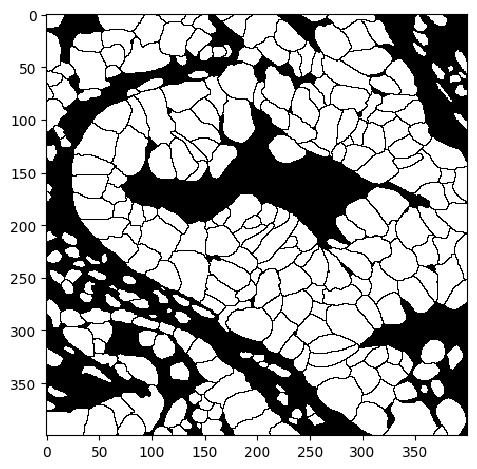

In [16]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [17]:
sam_output = model(image.unsqueeze(0).to(device))

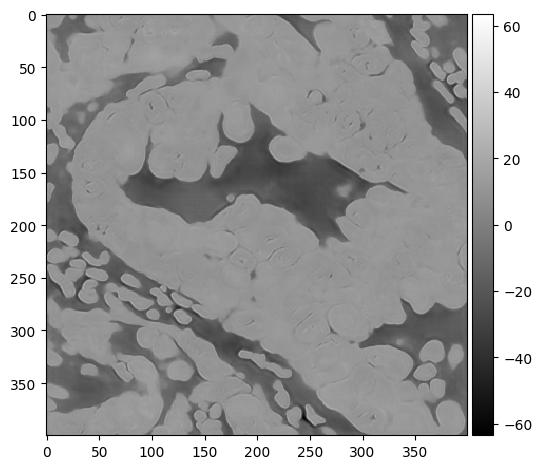

In [19]:
imshow(sam_output[0].squeeze().detach().cpu().numpy(), cmap="gray")

In [20]:
scaled_tensor = (sam_output[0] - torch.min(sam_output[0])) * (1.0 / (torch.max(sam_output[0]) - torch.min(sam_output[0])))

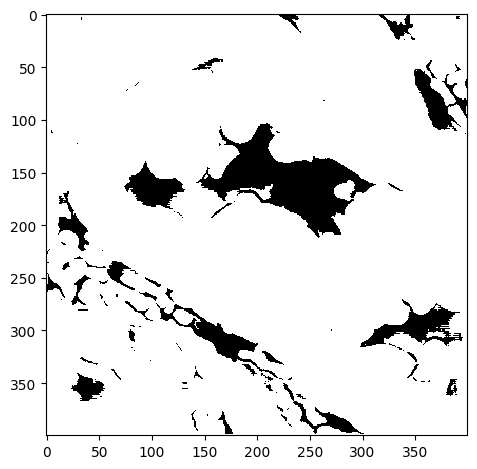

In [21]:
imshow(torch.round(scaled_tensor).detach().cpu().numpy().squeeze(), cmap='gray')